# Homework 2 - CutMix attempt

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/an2dl-mars/mars_for_students.npz


## Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec
import cv2
import keras_cv
from keras_cv import layers as cv_layers
from tensorflow.keras.regularizers import l2
from keras.models import Model
from tensorflow.keras import backend as K

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## Load the Data

In [ ]:
data = np.load("/kaggle/input/an2dl-mars/mars_for_students.npz")

training_set = data["training_set"]
X = training_set[:, 0]
y = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X.shape}")
print(f"Training y shape: {y.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


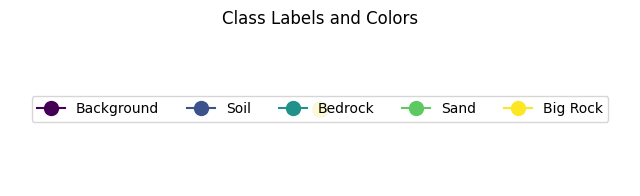

In [ ]:
class_labels = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

# Define a colormap with 5 distinct colors
colormap = plt.cm.get_cmap('viridis', len(class_labels))

# Create a visualization of class labels and colors
def visualize_colors():
    plt.figure(figsize=(8, 2))
    for class_id, class_name in class_labels.items():
        color = colormap(class_id / len(class_labels))  # Get color from colormap
        plt.plot(0, 0, marker='o', markersize=10, color=color, label=class_name)

    plt.legend(loc='center', ncol=len(class_labels))  # Display legend
    plt.axis('off')  # Hide axes
    plt.title("Class Labels and Colors")
    plt.show()
    plt.close()

visualize_colors()

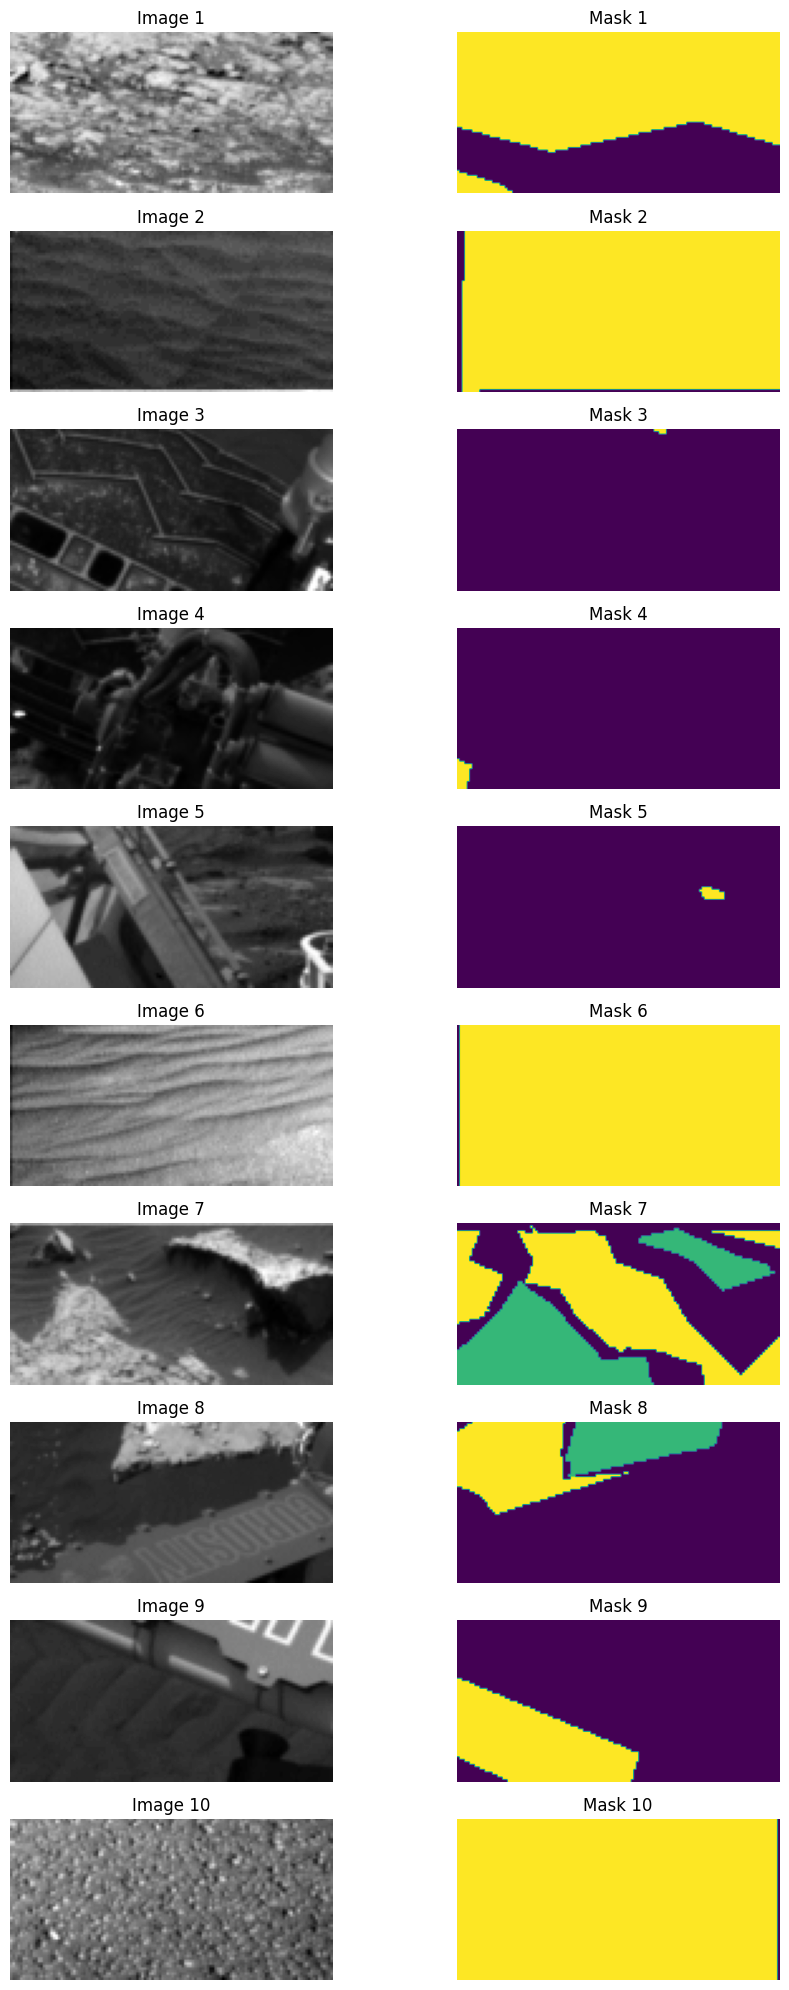

In [ ]:
# Définir le nombre d'exemples à afficher
num_examples = 10

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 2))

for i in range(num_examples):
    # Afficher l'image
    axes[i, 0].imshow(X[i], cmap="gray")
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Afficher le masque
    axes[i, 1].imshow(y[i], cmap="viridis")
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

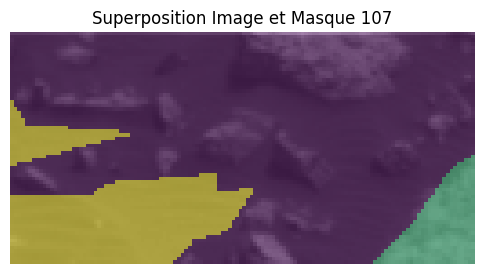

In [ ]:
# Visualisation d'une superposition image/masque
idx = 107  # Index d'exemple
plt.figure(figsize=(6, 6))
plt.imshow(X[idx], cmap="gray", alpha=0.8)
plt.imshow(y[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Superposition Image et Masque {idx}")
plt.axis("off")
plt.show()

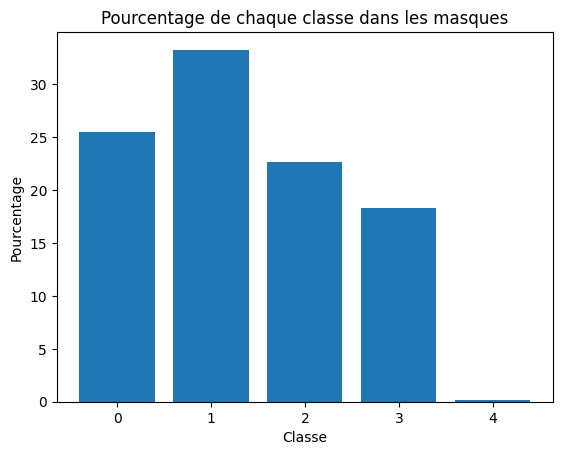

In [ ]:
# Pourcentage de pixels par classe
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
plt.bar(class_distribution.keys(), [100 * count / y.size for count in class_distribution.values()])
plt.title("Pourcentage de chaque classe dans les masques")
plt.xlabel("Classe")
plt.ylabel("Pourcentage")
plt.show()

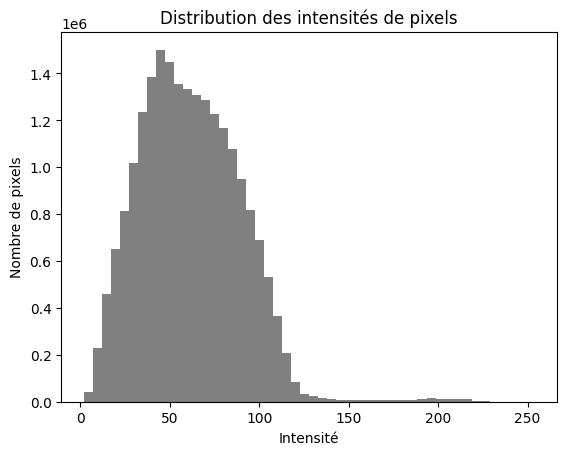

In [ ]:
# Tracer l'histogramme des intensités de pixels
plt.hist(X.flatten(), bins=50, color="gray")
plt.title("Distribution des intensités de pixels")
plt.xlabel("Intensité")
plt.ylabel("Nombre de pixels")
plt.show()

Text(0, 0.5, 'Count')

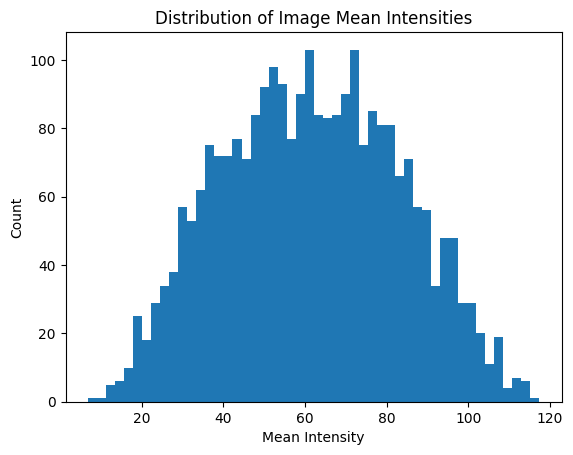

In [ ]:
# 2. Image Intensities
image_means = np.mean(X, axis=(1,2))
plt.hist(image_means, bins=50)
plt.title('Distribution of Image Mean Intensities')
plt.xlabel('Mean Intensity')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

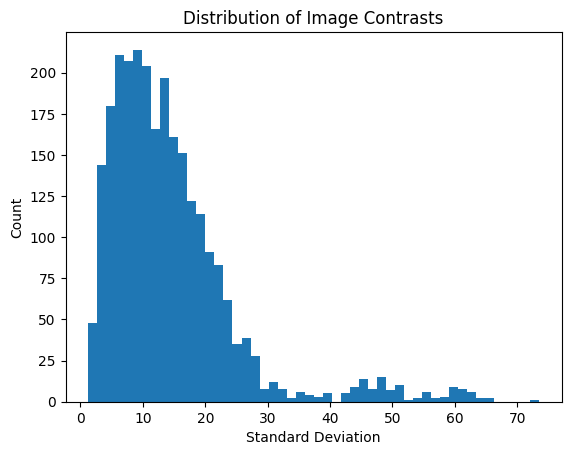

In [ ]:
# 3. Image Contrast
image_contrasts = np.std(X, axis=(1,2))
plt.hist(image_contrasts, bins=50)
plt.title('Distribution of Image Contrasts')
plt.xlabel('Standard Deviation')
plt.ylabel('Count')

## Preprocess data

### Remove Aliens

In [ ]:
# to remove only aliens
def find_same_images(image, images):
  indexes = []
  for i, img in enumerate(images):
    if np.array_equal(image, img):
      indexes.append(i)
  return indexes

In [ ]:
# we know that image #1224 is an alien
alien_indexes = find_same_images(y[1224], y)
print('we found ', len(alien_indexes), ' aliens')

X_aliens = X[alien_indexes]
X_filtered = np.delete(X, alien_indexes, axis=0)

y_aliens = y[alien_indexes]
y_filtered = np.delete(y, alien_indexes, axis=0)

print(f"X shape: {X.shape}")
print(f"Aliens X shape: {X_aliens.shape}")
print(f"New X shape: {X_filtered.shape}")

print(f"y shape: {y.shape}")
print(f"Removed y shape: {y_aliens.shape}")
print(f"New y shape: {y_filtered.shape}")

we found  110  aliens
X shape: (2615, 64, 128)
Aliens X shape: (110, 64, 128)
New X shape: (2505, 64, 128)
y shape: (2615, 64, 128)
Removed y shape: (110, 64, 128)
New y shape: (2505, 64, 128)


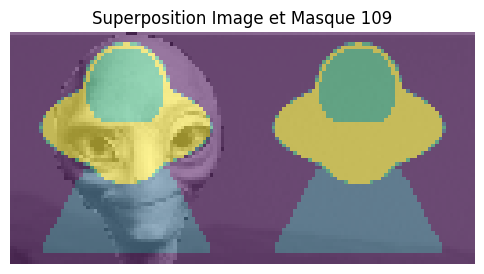

In [ ]:
# Visualisation d'une superposition image/masque
idx = 109  # Index d'exemple
plt.figure(figsize=(6, 6))
plt.imshow(X_aliens[idx], cmap="gray", alpha=0.8)
plt.imshow(y_aliens[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Superposition Image et Masque {idx}")
plt.axis("off")
plt.show()

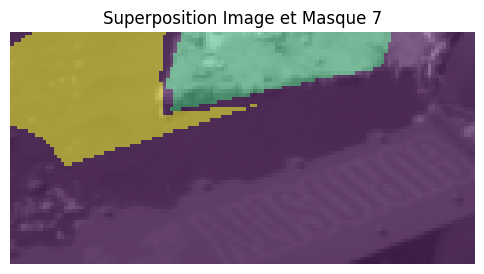

In [ ]:
# Visualisation d'une superposition image/masque
idx = 7  # Index d'exemple
plt.figure(figsize=(6, 6))
plt.imshow(X_filtered[idx], cmap="gray", alpha=0.8)
plt.imshow(y_filtered[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Superposition Image et Masque {idx}")
plt.axis("off")
plt.show()

## Augmentation test

In [ ]:
# Add color channel and rescale pixels between 0 and 1

X_filtered = X_filtered[..., np.newaxis] / 255.0
y_filtered = y_filtered[..., np.newaxis]
X_test = X_test[..., np.newaxis] / 255.0

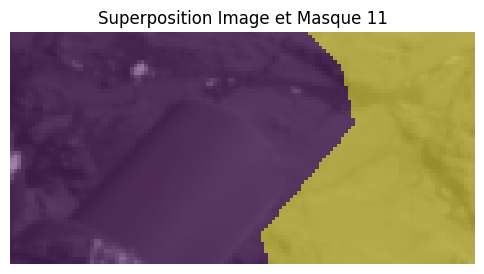

In [ ]:
# Visualisation d'une superposition image/masque
idx = 11 # Index d'exemple
plt.figure(figsize=(6, 6))
plt.imshow(X_filtered[idx], cmap="gray", alpha=0.8)
plt.imshow(y_filtered[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Superposition Image et Masque {idx}")
plt.axis("off")
plt.show()

In [ ]:
def augment_image_and_mask(image, mask, max_zoom=0.2, max_translation=0.1, target_size=[64, 128]):

    # Convertir l'image et le masque aux bons types
    image = tf.cast(image, tf.float32)  # Assurez-vous que l'image est en float32
    mask = tf.cast(mask, tf.int32)  # Le masque doit être en int32 (discrète)

    # Flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Rotation aléatoire
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    # Zoom (échelle) aléatoire
    scale = tf.random.uniform([], 1 - max_zoom, 1 + max_zoom)
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]
    new_height = tf.cast(tf.cast(original_height, tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * scale, tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    mask = tf.image.resize(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Décalage (translation) aléatoire
    shift_x = tf.cast(tf.random.uniform([], -max_translation, max_translation, dtype=tf.float32), tf.int32)
    shift_y = tf.cast(tf.random.uniform([], -max_translation, max_translation, dtype=tf.float32), tf.int32)
    image = tf.roll(image, shift=[shift_x, shift_y], axis=[0, 1])
    mask = tf.roll(mask, shift=[shift_x, shift_y], axis=[0, 1])

    # Ajustement de luminosité
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Ajustement de contraste
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Bruit gaussien
    noise_stddev = tf.random.uniform([], minval=0.0, maxval=0.001, dtype=tf.float32)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_stddev)
    image = tf.clip_by_value(image + noise, 0, 1)

    # Redimensionnement final
    image = tf.image.resize(image, target_size)
    mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Retourner l'image et le masque
    return image, mask

In [ ]:
augmented_image, augmented_mask = augment_image_and_mask(X_filtered[11], y_filtered[11])

print(augmented_image.shape)
print(augmented_mask.shape)

(64, 128, 1)
(64, 128, 1)


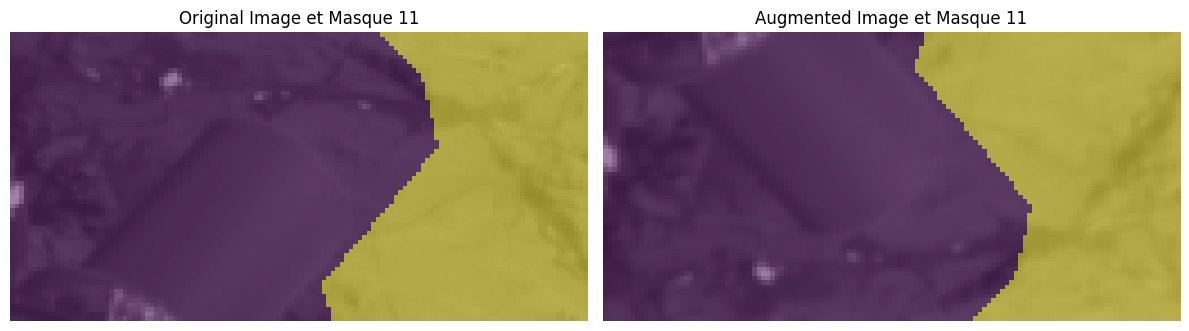

In [ ]:
# Visualisation côte à côte
idx = 11  # Index d'exemple

# Créer une figure avec 1 ligne et 2 colonnes
plt.figure(figsize=(12, 6))

# Premier graphique : Image originale et masque
plt.subplot(1, 2, 1)
plt.imshow(X_filtered[idx], cmap="gray", alpha=0.8)
plt.imshow(y_filtered[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Original Image et Masque {idx}")
plt.axis("off")

# Deuxième graphique : Image augmentée et masque augmentée
plt.subplot(1, 2, 2)
plt.imshow(augmented_image, cmap="gray", alpha=0.8)
plt.imshow(augmented_mask, cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Augmented Image et Masque {idx}")
plt.axis("off")

# Afficher les deux graphiques côte à côte
plt.tight_layout()
plt.show()


In [ ]:
def calculate_class_proportions(mask, class_labels=class_labels):
    # Aplatir l'image en un vecteur 1D
    flattened_mask = mask.flatten()

    # Compter les occurrences de chaque classe dans l'image
    unique, counts = np.unique(flattened_mask, return_counts=True)

    # Calculer la proportion de chaque classe
    total_pixels = flattened_mask.size
    proportions = {class_labels[class_idx]: count / total_pixels for class_idx, count in zip(unique, counts)}

    return proportions


In [ ]:
calculate_class_proportions(y_filtered[13])

{'Sand': 1.0}

In [ ]:
underrepresented_classes = ['Bedrock','Sand','Big Rock']

total = sum(calculate_class_proportions(y_filtered[13]).get(cls, 0) for cls in underrepresented_classes)
total

1.0

In [ ]:
# Classe à augmenter avec poids pour chaque classe
underrepresented_classes = {'Bedrock': 1.0, 'Sand': 1.0, 'Big Rock': 100.0}  # Poids plus élevé pour "Big Rock"

# Listes pour stocker les données augmentées
X_filtered_augmented_list = []
y_filtered_augmented_list = []

# Appliquer la transformation conditionnelle sur X_train
for image, mask in zip(X_filtered, y_filtered):
    # Calculer les proportions des classes
    proportions = calculate_class_proportions(mask, class_labels)

    # Calculer une proportion pondérée pour les classes sous-représentées
    weighted_proportion = sum(proportions.get(cls, 0) * weight for cls, weight in underrepresented_classes.items())

    # Augmenter si la proportion pondérée dépasse un seuil ajusté
    augment = weighted_proportion > 0.01

    if augment:
        # Augmentez l'image et le masque
        transformed_image, transformed_mask = augment_image_and_mask(image, mask)
        X_filtered_augmented_list.append(transformed_image)
        y_filtered_augmented_list.append(transformed_mask)

# Convertir les listes en arrays
X_filtered_augmented = np.array(X_filtered_augmented_list)
y_filtered_augmented = np.array(y_filtered_augmented_list)

# Combiner les données originales et augmentées
X_filtered_combined = np.concatenate([X_filtered, X_filtered_augmented], axis=0)
y_filtered_combined = np.concatenate([y_filtered, y_filtered_augmented], axis=0)

# Vérification des nouvelles tailles
print(f"X_train_combined shape: {X_filtered_combined.shape}")
print(f"y_train_combined shape: {y_filtered_combined.shape}")

X_train_combined shape: (4032, 64, 128, 1)
y_train_combined shape: (4032, 64, 128, 1)


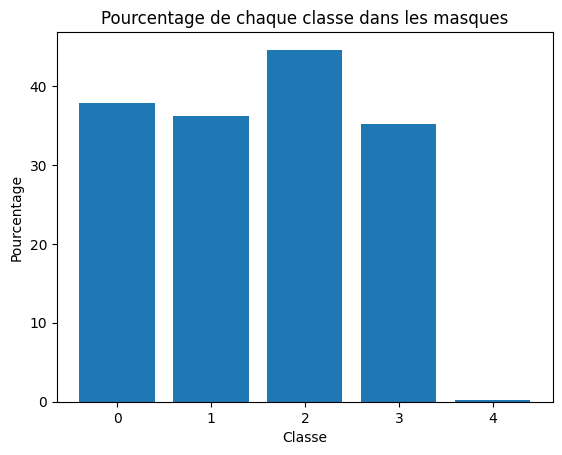

In [ ]:
# Pourcentage de pixels par classe
unique, counts = np.unique(y_filtered_combined, return_counts=True)
class_distribution = dict(zip(unique, counts))
plt.bar(class_distribution.keys(), [100 * count / y.size for count in class_distribution.values()])
plt.title("Pourcentage de chaque classe dans les masques")
plt.xlabel("Classe")
plt.ylabel("Pourcentage")
plt.show()

In [ ]:
def cutmix_augmentation(X, y, num_augmented):
    num_samples, h, w, c = X.shape
    X_augmented = []
    y_augmented = []

    for _ in range(num_augmented):
        # Sélectionner deux indices aléatoires dans le dataset
        i = random.randint(0, num_samples - 1)
        j = random.randint(0, num_samples - 1)

        # Générer une boîte aléatoire (cut region)
        cut_w = random.randint(1, w // 2)  # Largeur aléatoire
        cut_h = random.randint(1, h // 2)  # Hauteur aléatoire
        x1 = random.randint(0, w - cut_w)
        y1 = random.randint(0, h - cut_h)
        x2 = x1 + cut_w
        y2 = y1 + cut_h

        # Créer une nouvelle image et un nouveau masque
        X_new = np.copy(X[i])
        y_new = np.copy(y[i])
        X_new[y1:y2, x1:x2, :] = X[j, y1:y2, x1:x2, :]
        y_new[y1:y2, x1:x2, :] = y[j, y1:y2, x1:x2, :]

        # Ajouter les nouvelles images et masques au dataset augmenté
        X_augmented.append(X_new)
        y_augmented.append(y_new)

    # Convertir en numpy arrays
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    return X_augmented, y_augmented

In [ ]:
# Nombre d'images augmentées à générer
num_augmented = 10000

# Générer les images augmentées
X_cutmix, y_cutmix = cutmix_augmentation(X_filtered_combined, y_filtered_combined, num_augmented)

# Combiner avec le dataset d'origine
X_cutmix_combined = np.concatenate((X_filtered_combined, X_cutmix), axis=0)
y_cutmix_combined = np.concatenate((y_filtered_combined, y_cutmix), axis=0)

print(f"X_combined shape: {X_cutmix_combined.shape}")
print(f"y_combined shape: {y_cutmix_combined.shape}")

X_combined shape: (14032, 64, 128, 1)
y_combined shape: (14032, 64, 128, 1)


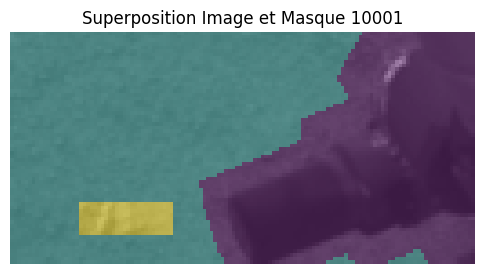

In [ ]:
# Visualisation d'une superposition image/masque
idx = 10001 # Index d'exemple
plt.figure(figsize=(6, 6))
plt.imshow(X_cutmix_combined[idx], cmap="gray", alpha=0.8)
plt.imshow(y_cutmix_combined[idx], cmap="viridis", alpha=0.5)  # Superposition avec transparence
plt.title(f"Superposition Image et Masque {idx}")
plt.axis("off")
plt.show()

In [ ]:
np.savez("augmented_dataset.npz", X=X_cutmix_combined, y=y_cutmix_combined)

## DataSet creation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_cutmix_combined, y_cutmix_combined, test_size=0.2)


num_classes = len(np.unique(y_train))


print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"num_classes: {num_classes}")

X_train: (11225, 64, 128, 1)
X_val: (2807, 64, 128, 1)
y_train: (11225, 64, 128, 1)
y_val: (2807, 64, 128, 1)
num_classes: 5


### X tensforflow dataset

To avoid over representation of classe 0 (background), that is already over represneted, we apply the transformation only to images for which classes 0 is less than 0.7

In [ ]:
def make_dataset(X_train, y_train, batch_size=32, shuffle=False):
    # Création du dataset de base
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size*3)

    # Préparation pour l'entraînement
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = make_dataset(X_train, y_train, shuffle=True)

for image, mask in train_dataset.take(1):
    print("Image shape:", image.shape, "dtype:", image.dtype, "List :", image.shape.as_list())
    print("Mask shape:", mask.shape, "dtype:", mask.dtype, "List :", mask.shape.as_list())

Image shape: (32, 64, 128, 1) dtype: <dtype: 'float64'> List : [32, 64, 128, 1]
Mask shape: (32, 64, 128, 1) dtype: <dtype: 'float64'> List : [32, 64, 128, 1]


### Y tensorflow dataset

In [ ]:
val_dataset = make_dataset(X_val, y_val)

for image, mask in val_dataset.take(1):
    print("Validation Image shape:", image.shape,"dtype:", image.dtype,"List :", image.shape.as_list())
    print("Validation Mask shape:", mask.shape, "dtype:", mask.dtype, "List :", mask.shape.as_list())

Validation Image shape: (32, 64, 128, 1) dtype: <dtype: 'float64'> List : [32, 64, 128, 1]
Validation Mask shape: (32, 64, 128, 1) dtype: <dtype: 'float64'> List : [32, 64, 128, 1]


## UNet Simple

with original data set : 0.47

with augmented dataset (only geometric transformation: + 1000 samples) : 0.41

with augmented dataset (cutmix and geometric: +10000 samples) : 0.7 locally, 0.46 on kaggle (more potential)

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

        # dropout actually made it perform worse
        # x = tfkl.Dropout(0.2, name=name + 'dropout' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=420):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')

    print('Unet model built!')
    return model

In [ ]:
# define params

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 100
# EPOCHS = 1 # used to test stuff

In [ ]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode='max',
    factor=0.1,
    patience=PATIENCE//2,
    min_lr=1e-5
)

callbacks = [early_stopping, scheduler]

In [ ]:
# build & describe the model

model = get_unet_model()
model.summary(expand_nested=True, show_trainable=True)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tfk.optimizers.AdamW(LEARNING_RATE, weight_decay = 5e-4)

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name='mean_iou')

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)

Unet model built!


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_3   │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │       512 │ down_block3_c… │   Y 

 Total params: 1,952,069 (7.45 MB)

 Trainable params: 1,949,253 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
).history

Epoch 1/100


W0000 00:00:1734182252.306136     347 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  3/351 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.1735 - loss: 1.9921 - mean_iou: 0.0439   

I0000 00:00:1734182260.822108     347 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4787 - loss: 1.2531 - mean_iou: 0.2295

W0000 00:00:1734182274.567993     349 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4791 - loss: 1.2522 - mean_iou: 0.2299

W0000 00:00:1734182282.947158     348 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734182284.628412     349 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.4793 - loss: 1.2518 - mean_iou: 0.2301 - val_accuracy: 0.2382 - val_loss: 3.1126 - val_mean_iou: 0.0658 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6429 - loss: 0.9041 - mean_iou: 0.3723 - val_accuracy: 0.6036 - val_loss: 1.0347 - val_mean_iou: 0.3409 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6784 - loss: 0.8224 - mean_iou: 0.3988 - val_accuracy: 0.5921 - val_loss: 1.0028 - val_mean_iou: 0.3213 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7030 - loss: 0.7605 - mean_iou: 0.4208 - val_accuracy: 0.6510 - val_loss: 0.9026 - val_mean_iou: 0.3498 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.7211 - loss: 0.7158 - mean_iou: 0.4354 - val_accuracy: 0.4182 - val_loss: 1.8025 - val_mean_iou: 0.1469 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━

In [ ]:
results = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]}, Validation MeanIoU: {results[1]}")

W0000 00:00:1734183576.580332     348 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9399 - loss: 0.3040 - mean_iou: 0.7193

W0000 00:00:1734183578.259711     346 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9398 - loss: 0.3040 - mean_iou: 0.7186
Validation Loss: 0.30402177572250366, Validation MeanIoU: 0.9381945729255676


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


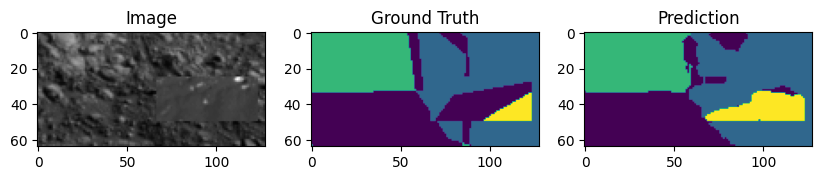

In [ ]:
model = tfk.models.load_model(model_filename)


def visualize_predictions(model, X, y, idx):
    pred = model.predict(X[idx][np.newaxis])
    pred_class = np.argmax(pred[0], axis=-1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X[idx].squeeze(), cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y[idx].squeeze(), cmap="viridis")
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred_class, cmap="viridis")
    plt.show()

visualize_predictions(model, X_val, y_val, idx=3)


In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_133944.keras


## Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_133944.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)